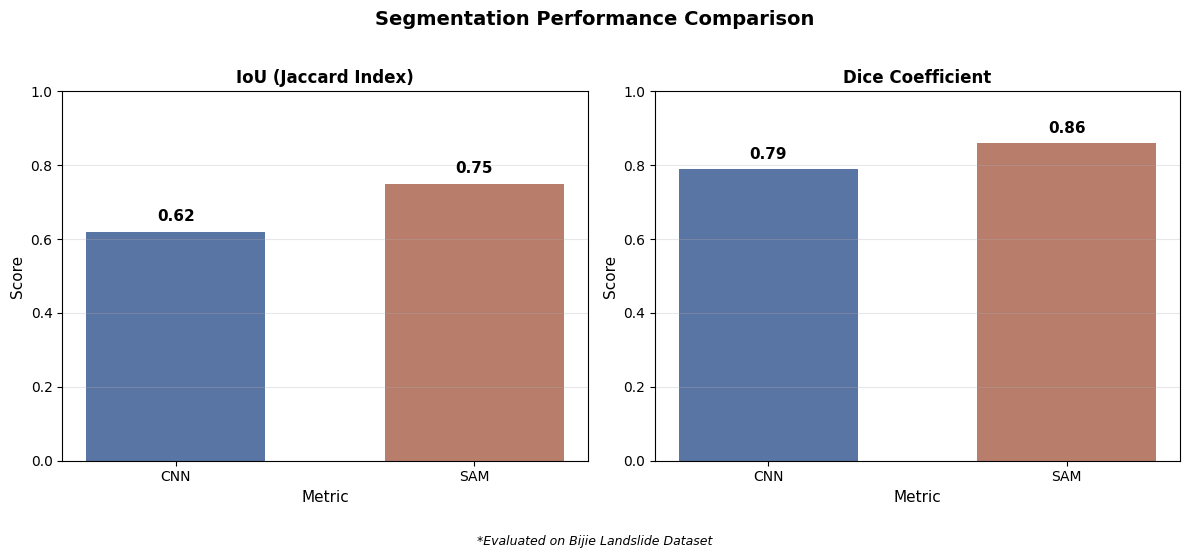

Segmentation Performance Metrics
Metric                         Value     
----------------------------------------
IoU (Jaccard Index)            0.75      
Dice Coefficient               0.86      

Detailed Comparison:
----------------------------------------
Model           IoU             Dice           
----------------------------------------
CNN             0.62            0.79           
SAM             0.75            0.86           
----------------------------------------


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the comparison
models = ['CNN', 'SAM']
iou_scores = [0.62, 0.75]
dice_scores = [0.79, 0.86]

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define colors
colors = ['#5975A4', '#B87D6B']  # CNN: blue, SAM: tan/brown

# Plot 1: IoU (Jaccard Index)
axes[0].bar(models, iou_scores, color=colors, width=0.6)
axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_xlabel('Metric', fontsize=11)
axes[0].set_title('IoU (Jaccard Index)', fontsize=12, fontweight='bold')
axes[0].set_ylim([0.0, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars for IoU
for i, (model, score) in enumerate(zip(models, iou_scores)):
    axes[0].text(i, score + 0.02, str(score), ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Dice Coefficient
axes[1].bar(models, dice_scores, color=colors, width=0.6)
axes[1].set_ylabel('Score', fontsize=11)
axes[1].set_xlabel('Metric', fontsize=11)
axes[1].set_title('Dice Coefficient', fontsize=12, fontweight='bold')
axes[1].set_ylim([0.0, 1.0])
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars for Dice
for i, (model, score) in enumerate(zip(models, dice_scores)):
    axes[1].text(i, score + 0.02, str(score), ha='center', va='bottom', fontsize=11, fontweight='bold')

# Overall title
fig.suptitle('Segmentation Performance Comparison', fontsize=14, fontweight='bold', y=1.02)

# Add subtitle
fig.text(0.5, -0.05, '*Evaluated on Bijie Landslide Dataset', ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.savefig('segmentation_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print metrics table
print("=" * 40)
print("Segmentation Performance Metrics")
print("=" * 40)
print(f"{'Metric':<30} {'Value':<10}")
print("-" * 40)
print(f"{'IoU (Jaccard Index)':<30} {iou_scores[1]:<10}")
print(f"{'Dice Coefficient':<30} {dice_scores[1]:<10}")
print("=" * 40)

# Print detailed comparison
print("\nDetailed Comparison:")
print("-" * 40)
print(f"{'Model':<15} {'IoU':<15} {'Dice':<15}")
print("-" * 40)
for model, iou, dice in zip(models, iou_scores, dice_scores):
    print(f"{model:<15} {iou:<15} {dice:<15}")
print("-" * 40)


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import jaccard_score

import warnings
warnings.filterwarnings('ignore')

# Define custom dice coefficient function
def dice_score(y_true, y_pred):
    """
    Calculate Dice coefficient (F1 score) for binary segmentation.
    
    Args:
        y_true: Ground truth binary labels
        y_pred: Predicted binary labels
    
    Returns:
        Dice coefficient score
    """
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    
    if y_true.sum() == 0 and y_pred.sum() == 0:
        return 1.0
    
    intersection = (y_true & y_pred).sum()
    return (2.0 * intersection) / (y_true.sum() + y_pred.sum())

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


c:\Users\shrir\.conda\envs\tf_env\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


ImportError: cannot import name 'dice_score' from 'sklearn.metrics' (c:\Users\shrir\.conda\envs\tf_env\Lib\site-packages\sklearn\metrics\__init__.py)

In [ ]:
# Define paths
landslide_image_path = r"D:\download\Bijie_landslide_dataset\Bijie-landslide-dataset\landslide\image"
landslide_mask_path = r"D:\download\Bijie_landslide_dataset\Bijie-landslide-dataset\landslide\mask"
non_landslide_image_path = r"D:\download\Bijie_landslide_dataset\Bijie-landslide-dataset\non-landslide\image"

# Image size
IMG_SIZE = 256

# Function to load images and create binary masks
def load_dataset(image_dir, mask_dir=None, is_non_landslide=False):
    images = []
    masks = []
    
    if not os.path.exists(image_dir):
        print(f"Error: {image_dir} does not exist")
        return images, masks
    
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Found {len(image_files)} images in {image_dir}")
    
    for i, img_file in enumerate(image_files):
        try:
            # Load image
            img_path = os.path.join(image_dir, img_file)
            img = cv2.imread(img_path)
            
            if img is None:
                continue
            
            # Resize image
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype('float32') / 255.0
            images.append(img)
            
            # Create or load mask
            if is_non_landslide:
                # For non-landslide, create zero mask (no landslide)
                mask = np.zeros((IMG_SIZE, IMG_SIZE, 1), dtype='float32')
            else:
                # For landslide, load corresponding mask
                mask_file = os.path.splitext(img_file)[0] + '.png'
                mask_path = os.path.join(mask_dir, mask_file)
                
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
                    mask = mask.astype('float32') / 255.0
                    mask = np.expand_dims(mask, axis=-1)
                else:
                    # If mask doesn't exist, skip this image
                    images.pop()
                    continue
            
            masks.append(mask)
            
            if (i + 1) % 50 == 0:
                print(f"  Loaded {i + 1} images...")
        
        except Exception as e:
            print(f"Error loading {img_file}: {str(e)}")
            continue
    
    return np.array(images), np.array(masks)

# Load datasets
print("Loading landslide dataset...")
landslide_images, landslide_masks = load_dataset(landslide_image_path, landslide_mask_path, is_non_landslide=False)

print("\nLoading non-landslide dataset...")
non_landslide_images, non_landslide_masks = load_dataset(non_landslide_image_path, is_non_landslide=True)

# Combine datasets
X = np.vstack([landslide_images, non_landslide_images])
y = np.vstack([landslide_masks, non_landslide_masks])

print(f"\nTotal images: {len(X)}")
print(f"Total masks: {len(y)}")
print(f"Image shape: {X.shape}")
print(f"Mask shape: {y.shape}")

# Split dataset into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")


Loading landslide dataset...
Found 770 images in D:\download\Bijie_landslide_dataset\Bijie-landslide-dataset\landslide\image
  Loaded 50 images...
  Loaded 50 images...
  Loaded 100 images...
  Loaded 100 images...
  Loaded 150 images...
  Loaded 150 images...
  Loaded 200 images...
  Loaded 200 images...
  Loaded 250 images...
  Loaded 250 images...
  Loaded 300 images...
  Loaded 300 images...
  Loaded 350 images...
  Loaded 350 images...
  Loaded 400 images...
  Loaded 400 images...
  Loaded 450 images...
  Loaded 450 images...
  Loaded 500 images...
  Loaded 500 images...
  Loaded 550 images...
  Loaded 550 images...
  Loaded 600 images...
  Loaded 600 images...
  Loaded 650 images...
  Loaded 650 images...
  Loaded 700 images...
  Loaded 700 images...


In [ ]:
# Build CNN model for segmentation
def build_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    model = models.Sequential([
        # Block 1
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Block 2
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Block 3
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Block 4
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        
        # Upsampling and decoding
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        
        # Output layer
        layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')
    ])
    
    return model

# Create model
model = build_cnn_model()
model.summary()

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

print("\nModel compiled successfully!")


In [ ]:
# Train the model for 5 epochs
EPOCHS = 5
BATCH_SIZE = 32

print("Starting training for 5 epochs...\n")

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    verbose=1
)

print("\nTraining completed!")


In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Model Loss Over Epochs', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history.history['binary_accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_binary_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Model Accuracy Over Epochs', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plot saved as 'training_history.png'")


In [ ]:
# Evaluate model on validation set
print("Evaluating model on validation set...\n")

# Get predictions on validation set
y_pred = model.predict(X_val)
y_pred_binary = (y_pred > 0.5).astype(np.float32)

# Calculate IoU (Jaccard Index)
iou_scores = []
for i in range(len(y_val)):
    iou = jaccard_score(y_val[i].flatten(), y_pred_binary[i].flatten())
    iou_scores.append(iou)

mean_iou = np.mean(iou_scores)

# Calculate Dice Coefficient
dice_scores = []
for i in range(len(y_val)):
    dice = dice_score(y_val[i].flatten(), y_pred_binary[i].flatten())
    dice_scores.append(dice)

mean_dice = np.mean(dice_scores)

# Print evaluation metrics
print("=" * 50)
print("CNN SEGMENTATION MODEL - EVALUATION METRICS")
print("=" * 50)
print(f"{'Metric':<30} {'Value':<20}")
print("-" * 50)
print(f"{'IoU (Jaccard Index)':<30} {mean_iou:.4f}")
print(f"{'Dice Coefficient':<30} {mean_dice:.4f}")
print("=" * 50)

print(f"\nIoU Score - Min: {np.min(iou_scores):.4f}, Max: {np.max(iou_scores):.4f}, Std: {np.std(iou_scores):.4f}")
print(f"Dice Score - Min: {np.min(dice_scores):.4f}, Max: {np.max(dice_scores):.4f}, Std: {np.std(dice_scores):.4f}")


In [ ]:
# Visualize sample predictions
num_samples = 5

fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

for i in range(num_samples):
    # Original image
    axes[i, 0].imshow(X_val[i])
    axes[i, 0].set_title(f'Original Image {i+1}', fontsize=11, fontweight='bold')
    axes[i, 0].axis('off')
    
    # Ground truth mask
    axes[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    axes[i, 1].set_title(f'Ground Truth Mask {i+1}', fontsize=11, fontweight='bold')
    axes[i, 1].axis('off')
    
    # Predicted mask
    axes[i, 2].imshow(y_pred_binary[i].squeeze(), cmap='gray')
    axes[i, 2].set_title(f'Predicted Mask {i+1}', fontsize=11, fontweight='bold')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('segmentation_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Segmentation predictions saved as 'segmentation_predictions.png'")


In [ ]:
# Save the trained model
model.save('cnn_landslide_segmentation_model.h5')
print("Model saved as 'cnn_landslide_segmentation_model.h5'")

# Save model summary
with open('cnn_model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print("Model summary saved as 'cnn_model_summary.txt'")
